In [2]:
import numpy as np
import matplotlib.pyplot as plt

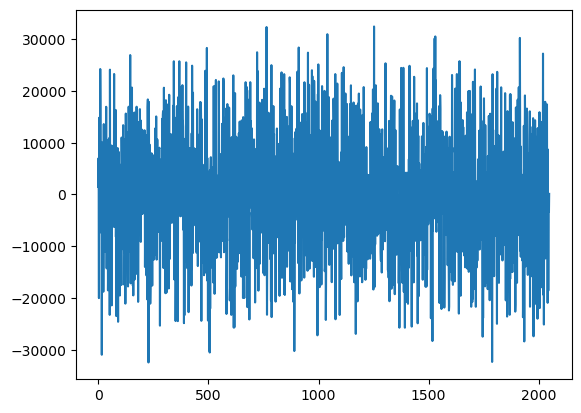

In [9]:
wave = np.fromfile('calibrator_231001.bin' ,dtype=np.int16)
plt.plot(wave)

In [25]:
Ns = len(wave) # basic waveform length
Nx = 16 # number of repetitions we want to generate
Npt = Ns * Nx # total length

In [26]:
# first way of doing it, is simply stacking the waveforms 8 times
wave_total_1 = np.hstack((wave,)*Nx)
assert(wave_total_1.shape == (Npt,))

In [28]:
# Now we are going to do the same in very complicated way, that will enable us to instute time delays without interpolations
# First we will transform the waveform into Fourier space and then generate the extended waveforms using "tones"

wave_f = np.fft.rfft(wave)
phi = np.arange(Npt)*2*np.pi/Ns
wave_total_2 = np.zeros(Ntpt)
for freq, comp in enumerate(wave_f):
    ## add to wave_total_2 the component at frequency freq
    pass

#assert(np.allclose(wave_total_1, wave_total_2))




In [ ]:
# Now turn the above into a function that can generate the waveform with arbirary clock drifts (f -> f*(1+clock_drift))

# Generate a large Nx waveform with Nx of 100000 or something.

# Write a function that pulls a single tone from this waveform using fft->pick up just coefficients aronud the frequency of interest --> fft back

# Use your previous code to fit the parameters of this tone, see if you can get the frequency and amplitude right